<a href="https://colab.research.google.com/github/sushgho/Msc-Project/blob/sushgho-patch-1/VGG_with_MNIST_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#tf.logging.set_verbosity(tf.logging.INFO)

%matplotlib inline
np.random.seed(1)

In [ ]:
pip install tensorflow==1.14


In [ ]:
pip install tensorflow-gpu==1.14

In [ ]:
# Loading the data (MNIST)
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


y = 0


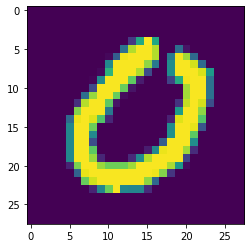

In [ ]:

index = 7
plt.imshow(train_data[index].reshape(28, 28))
print ("y = " + str(np.squeeze(train_labels[index])))

In [ ]:

print ("number of training examples = " + str(train_data.shape[0]))
print ("number of evaluation examples = " + str(eval_data.shape[0]))
print ("X_train shape: " + str(train_data.shape))
print ("Y_train shape: " + str(train_labels.shape))
print ("X_test shape: " + str(eval_data.shape))
print ("Y_test shape: " + str(eval_labels.shape))

number of training examples = 55000
number of evaluation examples = 10000
X_train shape: (55000, 784)
Y_train shape: (55000,)
X_test shape: (10000, 784)
Y_test shape: (10000,)


In [ ]:
def cnn_model_fn(features, labels, mode):
    # Input Layer
    input_height, input_width = 28, 28
    input_channels = 1
    input_layer = tf.reshape(features["x"], [-1, input_height, input_width, input_channels])

    # Convolutional Layer #1 and Pooling Layer #1
    conv1_1 = tf.layers.conv2d(inputs=input_layer, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv1_2 = tf.layers.conv2d(inputs=conv1_1, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1_2, pool_size=[2, 2], strides=2, padding="same")
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2_1 = tf.layers.conv2d(inputs=pool1, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv2_2 = tf.layers.conv2d(inputs=conv2_1, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2_2, pool_size=[2, 2], strides=2, padding="same")

    # Convolutional Layer #3 and Pooling Layer #3
    conv3_1 = tf.layers.conv2d(inputs=pool2, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv3_2 = tf.layers.conv2d(inputs=conv3_1, filters=256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3_2, pool_size=[2, 2], strides=2, padding="same")

    # Convolutional Layer #4 and Pooling Layer #4
    conv4_1 = tf.layers.conv2d(inputs=pool3, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv4_2 = tf.layers.conv2d(inputs=conv4_1, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(inputs=conv4_2, pool_size=[2, 2], strides=2, padding="same")

    # Convolutional Layer #5 and Pooling Layer #5
    conv5_1 = tf.layers.conv2d(inputs=pool4, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    conv5_2 = tf.layers.conv2d(inputs=conv5_1, filters=512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool5 = tf.layers.max_pooling2d(inputs=conv5_2, pool_size=[2, 2], strides=2, padding="same")

    # FC Layers
    pool5_flat = tf.contrib.layers.flatten(pool5)
    FC1 = tf.layers.dense(inputs=pool5_flat, units=4096, activation=tf.nn.relu)
    FC2 = tf.layers.dense(inputs=FC1, units=4096, activation=tf.nn.relu)
    FC3 = tf.layers.dense(inputs=FC2, units=1000, activation=tf.nn.relu)

    """the training argument takes a boolean specifying whether or not the model is currently 
    being run in training mode; dropout will only be performed if training is true. here, 
    we check if the mode passed to our model function cnn_model_fn is train mode. """
    dropout = tf.layers.dropout(inputs=FC3, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits Layer or the output layer. which will return the raw values for our predictions.
    # Like FC layer, logits layer is another dense layer. We leave the activation function empty 
    # so we can apply the softmax
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    # Then we make predictions based on raw output
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        # the predicted class for each example - a vlaue from 0-9
        "classes": tf.argmax(input=logits, axis=1),
        # to calculate the probablities for each target class we use the softmax
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    # so now our predictions are compiled in a dict object in python and using that we return an estimator object
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    
    '''Calculate Loss (for both TRAIN and EVAL modes): computes the softmax entropy loss. 
    This function both computes the softmax activation function as well as the resulting loss.'''
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Options (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels,
                                        predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode,
                                      loss=loss,
                                      eval_metric_ops=eval_metric_ops)

In [ ]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                          model_dir="/tmp/mnist_vgg13_model")

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": train_data},
                                                    y=train_labels,
                                                    batch_size=100,
                                                    num_epochs=100,
                                                    shuffle=True)
mnist_classifier.train(input_fn=train_input_fn,
                       steps=None,
                       hooks=None)

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": eval_data},
                                                   y=eval_labels,
                                                   num_epochs=1,
                                                   shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_vgg13_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6564c75f98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:C